In [28]:
!pip install dotenv

  Using cached python_dotenv-1.2.1-py3-none-any.whl.metadata (25 kB)
Using cached python_dotenv-1.2.1-py3-none-any.whl (21 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [dotenv]


## Importing Libs

In [46]:
import pandas as pd
import glob
import numpy as np
from datetime import time, timedelta
from textblob import TextBlob
import re
from sklearn.preprocessing import MinMaxScaler
import openai
from dotenv import load_dotenv
import os
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
import matplotlib.pyplot as plt

## Load all TSV Files

1. Load the news TSV files

2. Load the price TSV file

3. Convert timestamps / dates

4. Inspect a few rows

5. Check for missing values, duplicates, and basic consistency

In [10]:
tsv_files = glob.glob('news/*.tsv')
news_list = []
print(tsv_files)
for file in tsv_files:
    df = pd.read_csv(file, sep='\t')
    news_list.append(df)
    

# Combine all years into a single DataFrame
news_df = pd.concat(news_list, ignore_index=True)
print("Combined News DataFrame shape:", news_df.shape)

# Inspect first few rows
print("\nSample News Data:")
print(news_df.head())

# Convert 'timestamp' to datetime
news_df['timestamp'] = pd.to_datetime(news_df['timestamp'])
print("\nTimestamp column type after conversion:", news_df['timestamp'].dtype)

# Check for missing values
print("\nMissing values per column in news data:")
print(news_df.isnull().sum())

# Check for duplicates
print("\nNumber of duplicate rows in news data:", news_df.duplicated().sum())


# --- 2. Load price TSV file ---
price_df = pd.read_csv('price/temp_prices_2021_2024_anon.tsv', sep='\t')  # Replace with your path
print("\nPrice DataFrame shape:", price_df.shape)

# Inspect first few rows
print("\nSample Price Data:")
print(price_df.head())

# Convert 'date' to datetime
price_df['date'] = pd.to_datetime(price_df['date'])
print("\nDate column type after conversion:", price_df['date'].dtype)

# Check for missing values
print("\nMissing values per column in price data:")
print(price_df.isnull().sum())

# Check for duplicates
print("\nNumber of duplicate rows in price data:", price_df.duplicated().sum())

['news/temp_offerings_2021_anon.tsv', 'news/temp_offerings_2024_anon.tsv', 'news/temp_offerings_2023_anon.tsv', 'news/temp_offerings_2022_anon.tsv']
Combined News DataFrame shape: (2770, 4)

Sample News Data:
             timestamp symbol  \
0  2021-01-04 08:06:42   FWOM   
1  2021-01-04 09:27:19   HTYA   
2  2021-01-04 16:02:09   ZUOY   
3  2021-01-04 18:43:14   HUHZ   
4  2021-01-05 12:10:36   RCJI   

                                            headline  \
0  Happiness Biotech Announces Registered Direct ...   
1  AgEagle Aerial Systems Prices $6.375M Register...   
2  Fate Therapeutics Announces Proposed Offering ...   
3  AdaptHealth Announced 7M Share Proposed Public...   
4  ProPhase Labs Announces $5.5M Offering Of Stoc...   

                                                body  
0  NANPING, China, Jan. 4, 2021 /PRNewswire/ -- H...  
1  WICHITA, Kan., Jan. 04, 2021 (GLOBE NEWSWIRE) ...  
2  Fate Therapeutics Announces Proposed Public Of...  
3  AdaptHealth Corp. (NASDAQ: HUHZ 

## Filter Overnight News and Align with Price Data

1. Determine the overnight window for each trading day

    - Only keep news that arrives after the previous market close and before the current day’s open

2. Merge news with price data

    - For each symbol and date, attach the relevant overnight headlines

3. Aggregate multiple headlines per symbol per day (optional summaries, counts)

4. Inspect a few rows to confirm alignment between news and the correct open-to-close date

5. Check for missing matches

    - Identify trading days with no overnight news

    - Decide how to handle them (e.g., leave NaN or drop)

In [17]:
# --- 1. Sort price data by symbol and date ---
price_df = price_df.sort_values(['symbol', 'date']).reset_index(drop=True)

# --- 2. Compute previous day's close for each symbol ---
price_df['prev_close'] = price_df.groupby('symbol')['close'].shift(1)

# --- 3. Merge news to price by symbol, keeping only overnight news ---
# First, define the overnight window:
# News timestamp must be > previous close date's market close (assume 16:00 NY time)
# and <= current date's open (assuming 09:30 NY time)
# For simplicity, we’ll treat news timestamp <= current date 09:30 as overnight
# Add a "date" column to news corresponding to the target trading day
# If news arrives after previous day's close (16:00) and before current day open (09:30), it affects current day
news_df['date'] = news_df['timestamp'].dt.date  # Start with date portion
news_df['time'] = news_df['timestamp'].dt.time

# Function to filter overnight news
def is_overnight(news_time):
    # Overnight news is considered anytime after 16:00 previous day or before 09:30 current day
    return True  # We'll filter using price merging later

# --- 4. Merge news with price data (initial merge by symbol and date) ---
# For simplicity, we assign each headline to the **next trading day**
# Step 1: Get next trading day per symbol
# --- 1. Ensure both date columns are datetime64[ns] ---
# Convert news_df['timestamp'] to datetime if not already
news_df['timestamp'] = pd.to_datetime(news_df['timestamp'])

# Create 'next_date' in price_df as datetime64[ns] (date only)
price_df['next_date'] = price_df.groupby('symbol')['date'].shift(-1)

# Make news_df['date'] also datetime64[ns], using only date (normalize to midnight)
news_df['date'] = pd.to_datetime(news_df['timestamp'].dt.date)

# --- 2. Merge using datetime64[ns] columns ---
merged_df = price_df.merge(news_df, left_on=['symbol', 'next_date'], right_on=['symbol', 'date'], how='left')

print("Merged DataFrame shape:", merged_df.shape)
# --- 5. Aggregate headlines per symbol per day ---
# For simplicity, we can count number of headlines and concatenate headline texts
agg_df = merged_df.groupby(['symbol', 'date_x']).agg({
    'open': 'first',
    'close': 'first',
    'prev_close': 'first',
    'headline': lambda x: ' || '.join(x.dropna()),  # combine headlines
    'body': lambda x: ' || '.join(x.dropna()),      # combine bodies
}).reset_index()

# Rename date column
agg_df = agg_df.rename(columns={'date_x': 'date'})

print("\nAggregated DataFrame shape:", agg_df.shape)
print("\nSample aggregated data:")
print(agg_df.head())

# --- 6. Compute target: open-to-close return ---
agg_df['open_to_close_return'] = (agg_df['close'] - agg_df['open']) / agg_df['open']
print("\nSample returns:")
print(agg_df[['symbol', 'date', 'open', 'close', 'open_to_close_return']].head())

# --- 7. Check for missing headlines ---
missing_news = agg_df['headline'].isna().sum()
print(f"\nNumber of trading days with no overnight news: {missing_news}")


Merged DataFrame shape: (1137973, 14)

Aggregated DataFrame shape: (1137837, 7)

Sample aggregated data:
  symbol       date  open  close  prev_close headline body
0   AAAZ 2021-11-01  2.24   2.37         NaN              
1   AAAZ 2021-11-02  2.38   2.39        2.37              
2   AAAZ 2021-11-03  2.43   2.50        2.39              
3   AAAZ 2021-11-04  2.50   2.44        2.50              
4   AAAZ 2021-11-05  2.46   2.44        2.44              

Sample returns:
  symbol       date  open  close  open_to_close_return
0   AAAZ 2021-11-01  2.24   2.37              0.058036
1   AAAZ 2021-11-02  2.38   2.39              0.004202
2   AAAZ 2021-11-03  2.43   2.50              0.028807
3   AAAZ 2021-11-04  2.50   2.44             -0.024000
4   AAAZ 2021-11-05  2.46   2.44             -0.008130

Number of trading days with no overnight news: 0


## Feature Construction

1. Add binary “has_news” indicator → tells if any headlines exist for the day.

2. Normalize numeric features → scale body_length and keyword_count for stability.

3. summarize headlines using GPT-4o-mini → we can extract a coarse, interpretable embedding or summary for advanced features.

In [30]:

load_dotenv()  # loads .env file in the current directory
openai.api_key = os.getenv("OPENAI_API_KEY")

# Check that key is loaded (prints only if key exists)
if openai.api_key:
    print("OpenAI API key loaded ✅")
else:
    print("OpenAI API key not found ❌")
    
# --- 1. Headline count ---
agg_df['headline_count'] = agg_df['headline'].apply(lambda x: 0 if pd.isna(x) or x.strip() == '' else len(x.split(' || ')))

# --- 2. Body length (words) ---
agg_df['body_length'] = agg_df['body'].apply(lambda x: 0 if pd.isna(x) or x.strip() == '' else len(x.split()))

# --- 3. Simple sentiment using TextBlob on headlines ---
def sentiment_score(text):
    if pd.isna(text) or text.strip() == '':
        return 0
    blob = TextBlob(text)
    return blob.sentiment.polarity  # -1 to +1

agg_df['headline_sentiment'] = agg_df['headline'].apply(sentiment_score)

# --- 4. Keyword indicators ---
keywords = ['offering', 'equity', 'debt', 'funding', 'issuance', 'capital']
def keyword_count(text):
    if pd.isna(text) or text.strip() == '':
        return 0
    text = text.lower()
    return sum(text.count(word) for word in keywords)

agg_df['keyword_count'] = agg_df['headline'].apply(keyword_count)

# --- 5. Binary feature: has_news ---
agg_df['has_news'] = (agg_df['headline_count'] > 0).astype(int)

# --- 6. Normalize numeric features ---
scaler = MinMaxScaler()
agg_df[['body_length_norm', 'keyword_count_norm']] = scaler.fit_transform(
    agg_df[['body_length', 'keyword_count']]
)

# --- 7. Optional: GPT-4o-mini summarization (coarse) ---
# Example: create a short 1-line summary of all headlines per day
def summarize_headlines(text):
    if pd.isna(text) or text.strip() == '':
        return ''
    try:
        response = openai.ChatCompletion.create(
            model="gpt-4o-mini",
            messages=[
                {"role": "system", "content": "Summarize the following headlines into a single short phrase highlighting offering news."},
                {"role": "user", "content": text}
            ],
            temperature=0
        )
        summary = response.choices[0].message['content']
        return summary
    except Exception as e:
        return f"Error: {e}"

# Example: generate summaries for first 5 rows only to test
agg_df['headline_summary'] = agg_df['headline'].head(5).apply(summarize_headlines)
print("\nSample summaries:")
print(agg_df[['symbol','date','headline_summary']].head())

# --- 8. Print checks ---
print("\nSample enhanced features:")
print(agg_df[['symbol','date','headline_count','body_length','headline_sentiment',
              'keyword_count','has_news','body_length_norm','keyword_count_norm','open_to_close_return']].head())

print("\nFeature statistics after normalization:")
print(agg_df[['headline_count','body_length','headline_sentiment','keyword_count','has_news','body_length_norm','keyword_count_norm']].describe())

OpenAI API key loaded ✅

Sample summaries:
  symbol       date headline_summary
0   AAAZ 2021-11-01                 
1   AAAZ 2021-11-02                 
2   AAAZ 2021-11-03                 
3   AAAZ 2021-11-04                 
4   AAAZ 2021-11-05                 

Sample enhanced features:
  symbol       date  headline_count  body_length  headline_sentiment  \
0   AAAZ 2021-11-01               0            0                 0.0   
1   AAAZ 2021-11-02               0            0                 0.0   
2   AAAZ 2021-11-03               0            0                 0.0   
3   AAAZ 2021-11-04               0            0                 0.0   
4   AAAZ 2021-11-05               0            0                 0.0   

   keyword_count  has_news  body_length_norm  keyword_count_norm  \
0              0         0               0.0                 0.0   
1              0         0               0.0                 0.0   
2              0         0               0.0                 0.0   
3  

## Train/Test Split and Baseline Model

1. Training on a moving window of past dates

2. Testing on the next period

3. Evaluating performance over time instead of a single split



In [33]:

# --- 1. Sort by symbol and date ---
agg_df = agg_df.sort_values(['symbol', 'date']).reset_index(drop=True)

# --- 2. Time-based split ---
# Option 1: Use last 20% of unique dates as test set
unique_dates = sorted(agg_df['date'].unique())
split_idx = int(len(unique_dates) * 0.8)
train_dates = unique_dates[:split_idx]
test_dates = unique_dates[split_idx:]

train_df = agg_df[agg_df['date'].isin(train_dates)]
test_df = agg_df[agg_df['date'].isin(test_dates)]

print(f"Train shape: {train_df.shape}, Test shape: {test_df.shape}")

# --- 3. Select features and target ---
feature_cols = ['headline_count','body_length_norm','headline_sentiment','keyword_count_norm','has_news']
target_col = 'open_to_close_return'

X_train = train_df[feature_cols]
y_train = train_df[target_col]
X_test = test_df[feature_cols]
y_test = test_df[target_col]

# --- Remove rows with NaN in target ---
train_df = train_df.dropna(subset=[target_col])
test_df = test_df.dropna(subset=[target_col])

# Re-define X and y
X_train = train_df[feature_cols]
y_train = train_df[target_col]
X_test = test_df[feature_cols]
y_test = test_df[target_col]

print(f"After dropping NaNs: Train shape: {X_train.shape}, Test shape: {X_test.shape}")


# --- 4. Linear Regression ---
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

# --- 5. Evaluate regression ---
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"\nLinear Regression Performance:")
print(f"MSE: {mse:.6f}, R^2: {r2:.4f}")

# --- 6. Optional: Binary classification (sign of return) ---
train_sign = (y_train > 0).astype(int)
test_sign = (y_test > 0).astype(int)

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, train_sign)
sign_pred = clf.predict(X_test)
acc = accuracy_score(test_sign, sign_pred)
print(f"\nBinary Sign Prediction Accuracy: {acc:.4f}")

# --- 7. Feature importance (for linear regression) ---
coef_df = pd.DataFrame({'feature': feature_cols, 'coefficient': lr.coef_})
print("\nLinear Regression Feature Coefficients:")
print(coef_df)

Train shape: (917667, 16), Test shape: (220170, 16)
After dropping NaNs: Train shape: (915848, 5), Test shape: (219532, 5)

Linear Regression Performance:
MSE: 0.473732, R^2: -75.1952

Binary Sign Prediction Accuracy: 0.5449

Linear Regression Feature Coefficients:
              feature  coefficient
0      headline_count     0.069283
1    body_length_norm    -0.035365
2  headline_sentiment     0.035166
3  keyword_count_norm    -0.163667
4            has_news    -0.710700


## Rolling Walk-Forward Evaluation

1. Train on a moving window of past data (e.g., 1 year or 80% of past dates)

2. Test on the next period (e.g., next month, quarter, or year)

3. Evaluate both regression (returns) and binary sign prediction

4. Track performance over time to check signal stability

In [44]:

# --- Parameters for walk-forward ---
window_size = int(len(unique_dates) * 0.6)  # training window ~60% of dates
step_size = 30  # advance by 30 days per window
min_news = 50   # only include windows with at least 50 news rows

results = []

for start_idx in range(0, len(unique_dates) - window_size, step_size):
    train_dates = unique_dates[start_idx:start_idx + window_size]
    test_dates = unique_dates[start_idx + window_size:start_idx + window_size + step_size]
    
    train_df_window = agg_df[agg_df['date'].isin(train_dates)].dropna(subset=[target_col])
    test_df_window = agg_df[agg_df['date'].isin(test_dates)].dropna(subset=[target_col])
    
    test_news_count = test_df_window['has_news'].sum()
    
    if len(test_df_window) == 0 or test_news_count < min_news:
        continue  # skip low-news windows
    
    X_train = train_df_window[feature_cols]
    y_train = train_df_window[target_col]
    X_test = test_df_window[feature_cols]
    y_test = test_df_window[target_col]
    
    # Linear Regression
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    
    # Binary Sign Prediction
    train_sign = (y_train > 0).astype(int)
    test_sign = (y_test > 0).astype(int)
    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_train, train_sign)
    sign_pred = clf.predict(X_test)
    acc = accuracy_score(test_sign, sign_pred)
    
    results.append({
        'train_start': train_dates[0],
        'train_end': train_dates[-1],
        'test_start': test_dates[0],
        'test_end': test_dates[-1],
        'mse': mse,
        'sign_acc': acc,
        'test_news_count': test_news_count
    })

results_df = pd.DataFrame(results)
print("\nFiltered Rolling Walk-Forward Evaluation Results:")
print(results_df)



Filtered Rolling Walk-Forward Evaluation Results:
   train_start  train_end test_start   test_end       mse  sign_acc  \
0   2021-11-01 2023-09-25 2023-09-26 2023-11-06  0.837891  0.550169   
1   2021-12-14 2023-11-06 2023-11-07 2023-12-19  0.823147  0.502918   
2   2022-01-27 2023-12-19 2023-12-20 2024-02-02  0.824885  0.545871   
3   2022-03-11 2024-02-02 2024-02-05 2024-03-18  0.820143  0.532758   
4   2022-04-25 2024-03-18 2024-03-19 2024-04-30  0.827264  0.553707   
5   2022-06-07 2024-04-30 2024-05-01 2024-06-12  0.822927  0.534761   
6   2022-07-21 2024-06-12 2024-06-13 2024-07-26  0.826178  0.531087   
7   2022-09-01 2024-07-26 2024-07-29 2024-09-09  0.005367  0.566073   
8   2022-10-14 2024-09-09 2024-09-10 2024-10-21  0.005393  0.530204   
9   2022-11-28 2024-10-21 2024-10-22 2024-12-03  0.006152  0.541048   
10  2023-01-11 2024-12-03 2024-12-04 2024-12-31  0.010013  0.557858   

    test_news_count  
0                71  
1                80  
2                63  
3       

## Visualization

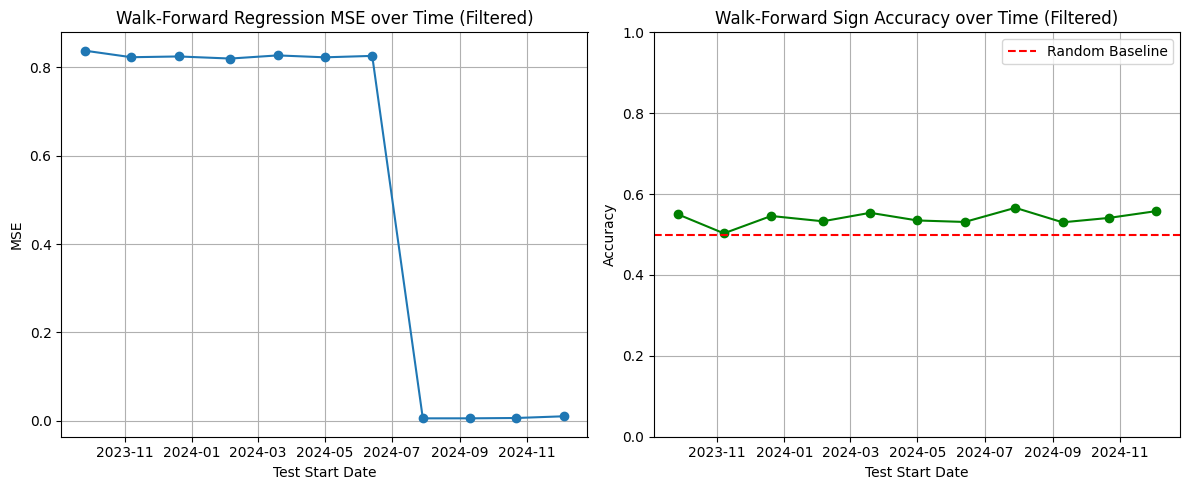

In [47]:

results_df['train_start'] = pd.to_datetime(results_df['train_start'])
results_df['test_start'] = pd.to_datetime(results_df['test_start'])

plt.figure(figsize=(12,5))

# Regression MSE
plt.subplot(1,2,1)
plt.plot(results_df['test_start'], results_df['mse'], marker='o', linestyle='-')
plt.title('Walk-Forward Regression MSE over Time (Filtered)')
plt.xlabel('Test Start Date')
plt.ylabel('MSE')
plt.grid(True)

# Sign Accuracy
plt.subplot(1,2,2)
plt.plot(results_df['test_start'], results_df['sign_acc'], marker='o', linestyle='-', color='green')
plt.axhline(0.5, color='red', linestyle='--', label='Random Baseline')
plt.title('Walk-Forward Sign Accuracy over Time (Filtered)')
plt.xlabel('Test Start Date')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()